# Using ML classification models to predict status of loan repayment

Accuracy methods used to determine best model: F1 Scores, Jaccard, Logloss, Confusion Matrix

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

Dataset Desc

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-21 15:38:37--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2020-08-21 15:38:37 (14.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
Unnamed: 0        346 non-null int64
Unnamed: 0.1      346 non-null int64
loan_status       346 non-null object
Principal         346 non-null int64
terms             346 non-null int64
effective_date    346 non-null object
due_date          346 non-null object
age               346 non-null int64
education         346 non-null object
Gender            346 non-null object
dtypes: int64(5), object(5)
memory usage: 27.1+ KB


### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [11]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [9]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

<Figure size 720x432 with 0 Axes>

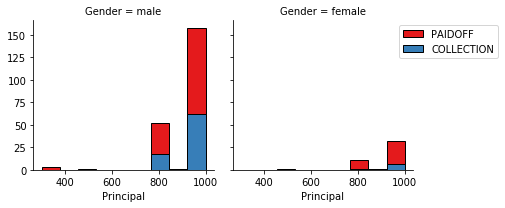

In [6]:
import seaborn as sns
plt.figure(figsize=(10,6))
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

plt.legend(bbox_to_anchor=(1.5, 1))


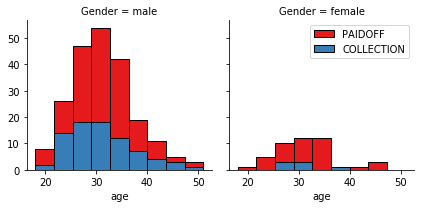

In [7]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins,ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

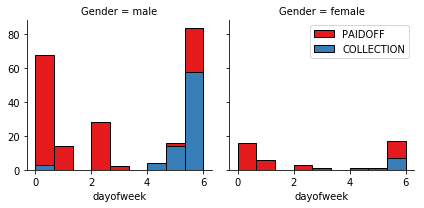

<Figure size 864x432 with 0 Axes>

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.figure(figsize=(12,6))
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [24]:
#df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.groupby(['loan_status','Gender'])['dayofweek'].value_counts()

loan_status  Gender  dayofweek
COLLECTION   female  6             7
             male    6            58
                     5            14
                     4             4
                     0             3
PAIDOFF      female  6            17
                     0            16
                     1             6
                     2             3
                     3             1
                     4             1
                     5             1
             male    6            84
                     0            68
                     2            28
                     5            16
                     1            14
                     4             3
                     3             2
Name: dayofweek, dtype: int64

## Convert Categorical features to numerical values

Lets look at gender:

In [25]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [26]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4


## One Hot Encoding  
#### How about education?

education             loan_status
Bechalor              PAIDOFF         33
                      COLLECTION      11
High School or Below  PAIDOFF        112
                      COLLECTION      39
Master or Above       COLLECTION       1
                      PAIDOFF          1
college               PAIDOFF        114
                      COLLECTION      35
Name: loan_status, dtype: int64

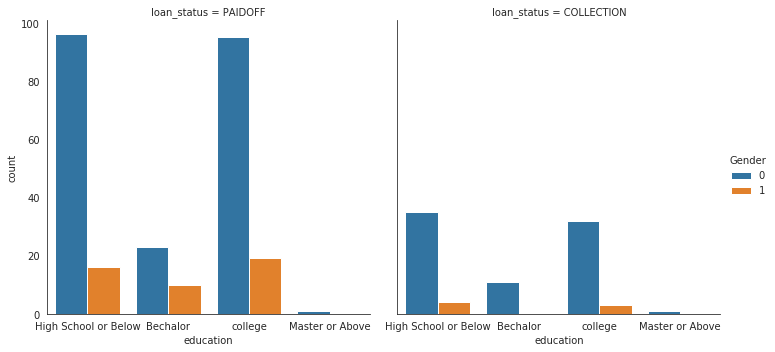

In [17]:
g = sns.catplot(x="education", hue="Gender", col="loan_status",
                data=df, kind="count")
sns.set_style('white')

df.groupby(['education'])['loan_status'].value_counts()

#### Feature befor One Hot Encoding

In [20]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [27]:
Feature = df[['Principal','terms','age','Gender','dayofweek']]
Feature.head()

,Principal,terms,age,Gender,dayofweek
0,1000,30,45,0,3
1,1000,30,33,1,3
2,1000,15,27,0,3
3,1000,30,28,1,4
4,1000,30,29,0,4


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [28]:
Feature = df[['Principal','terms','age','Gender','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,3,0,1,0
1,1000,30,33,1,3,1,0,0
2,1000,15,27,0,3,0,0,1
3,1000,30,28,1,4,0,0,1
4,1000,30,29,0,4,0,0,1


### Feature selection

Lets defind feature sets, X:

In [29]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,3,0,1,0
1,1000,30,33,1,3,1,0,0
2,1000,15,27,0,3,0,0,1
3,1000,30,28,1,4,0,0,1
4,1000,30,29,0,4,0,0,1


What are our labels?

In [30]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [31]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -0.26122054,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -0.26122054,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -0.26122054,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.12175534,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.12175534,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
import sklearn.metrics as metrics

In [33]:
X= preprocessing.StandardScaler().fit(X).transform(X)
y = df['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

K value: 7 returns min error rate of 0.221
[[ 6 20]
 [ 3 75]]


              precision    recall  f1-score   support

  COLLECTION       0.67      0.23      0.34        26
     PAIDOFF       0.79      0.96      0.87        78

   micro avg       0.78      0.78      0.78       104
   macro avg       0.73      0.60      0.60       104
weighted avg       0.76      0.78      0.74       104



KNN Jaccard Score: 0.7788461538461539


KNN F1: 0.867


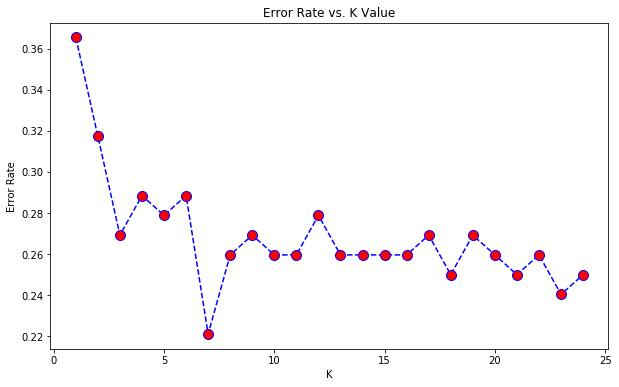

In [37]:
error_rate = []

for i in range(1,25):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,25),error_rate,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

min_error = min(error_rate)
k_neighbor = error_rate.index(min_error)+1
print('K value:',k_neighbor,'returns min error rate of',round(min_error,3))

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))
print('\n')
knn_jaccard = jaccard_similarity_score(y_test,pred)
print('KNN Jaccard Score:',knn_jaccard)
print('\n')
knn_f1 = f1_score(y_test,pred, pos_label='PAIDOFF')
print('KNN F1:',round(knn_f1,3))


In [38]:
score = []
for k in range(1,25):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred=knn.predict(X_test)
    accuracy=metrics.accuracy_score(pred,y_test)
    score.append(accuracy*100)
    
print('max accuracy score of:',round(max(score),2), 'at K =',score.index(max(score))+1)


max accuracy score of: 77.88 at K = 7


In [39]:
pred

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
     

# Decision Tree

In [40]:
X= preprocessing.StandardScaler().fit(X).transform(X)
y = df['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=20)

In [41]:
from sklearn.tree import DecisionTreeClassifier

max accuracy score of: 0.7 at Depth = 9


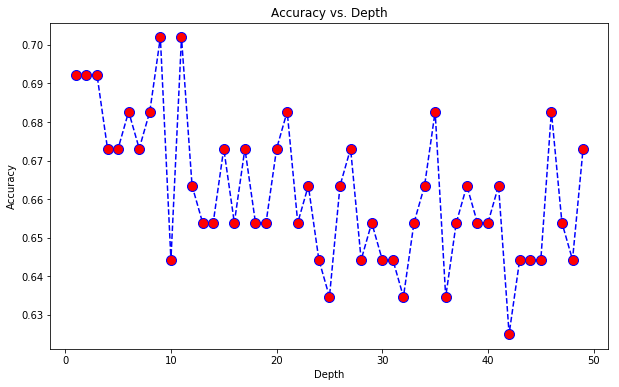

In [42]:
accuracy_score = []
max_depths = 50
for i in range(1,max_depths):
    dtree = DecisionTreeClassifier(max_depth=i)
    dtree.fit(X_train, y_train)
    predictions = dtree.predict(X_test)
    accuracy_score.append(metrics.accuracy_score(y_test,predictions))
    #print("Decision tree accuracy for max_depth = {} is {}".format(i,metrics.accuracy_score(y_test,predictions)))

plt.figure(figsize=(10,6))
plt.plot(range(1,50),accuracy_score,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')

print('max accuracy score of:',round(max(accuracy_score),2), 'at Depth =',accuracy_score.index(max(accuracy_score))+1)

In [43]:
dtree = DecisionTreeClassifier(max_depth=9)
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)
predictions

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 

In [44]:
print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))
print('\n')
dtree_f1 = f1_score(y_test, predictions, pos_label='PAIDOFF')
print('Decision Tree F1:',round(dtree_f1,3))
print('\n')
dtree_jaccard = jaccard_similarity_score(y_test,predictions)
print('Jaccard Similarity Score using Decision Trees:',round(dtree_jaccard,3))

              precision    recall  f1-score   support

  COLLECTION       0.52      0.34      0.42        32
     PAIDOFF       0.75      0.86      0.80        72

   micro avg       0.70      0.70      0.70       104
   macro avg       0.64      0.60      0.61       104
weighted avg       0.68      0.70      0.68       104



[[11 21]
 [10 62]]


Decision Tree F1: 0.8


Jaccard Similarity Score using Decision Trees: 0.702


# Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

  COLLECTION       0.52      0.34      0.42        32
     PAIDOFF       0.75      0.86      0.80        72

   micro avg       0.70      0.70      0.70       104
   macro avg       0.64      0.60      0.61       104
weighted avg       0.68      0.70      0.68       104



[[11 21]
 [10 62]]


# Support Vector Machine

In [48]:
from sklearn.svm import SVC

In [49]:
svc = SVC()
svc.fit(X_train,y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [50]:
predictions = svc.predict(X_test)
predictions

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 

In [51]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))
print('\n')
svc_jaccard = jaccard_similarity_score(y_test,predictions)
print('Jaccard Similarity Score using SVC:',round(svc_jaccard,3))
print('\n')
svc_f1 = f1_score(y_test, predictions, pos_label='PAIDOFF')
print('SVC F1:',round(svc_f1,3))

[[ 0 32]
 [ 1 71]]


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        32
     PAIDOFF       0.69      0.99      0.81        72

   micro avg       0.68      0.68      0.68       104
   macro avg       0.34      0.49      0.41       104
weighted avg       0.48      0.68      0.56       104



Jaccard Similarity Score using SVC: 0.683


SVC F1: 0.811


# Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
lm = LogisticRegression()

In [54]:
lm.fit(X_train,y_train)
pred = lm.predict(X_test)
pred

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF

In [56]:
print(classification_report(y_test,pred))
print('\n')
log_loss_pred = lm.predict_proba(X_test)
lm_log_loss_score = log_loss(y_test, log_loss_pred)
print('Log Loss for Regression Model:',round(lm_log_loss_score,3))

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        32
     PAIDOFF       0.69      0.99      0.81        72

   micro avg       0.68      0.68      0.68       104
   macro avg       0.34      0.49      0.41       104
weighted avg       0.48      0.68      0.56       104



Log Loss for Regression Model: 0.537


# Model Evaluation using Test set

In [36]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [57]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-21 15:49:17--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-08-21 15:49:17 (373 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [58]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 10 columns):
Unnamed: 0        54 non-null int64
Unnamed: 0.1      54 non-null int64
loan_status       54 non-null object
Principal         54 non-null int64
terms             54 non-null int64
effective_date    54 non-null object
due_date          54 non-null object
age               54 non-null int64
education         54 non-null object
Gender            54 non-null object
dtypes: int64(5), object(5)
memory usage: 4.3+ KB


In [59]:
# Data Preparation
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
#test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [60]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 11 columns):
Unnamed: 0        54 non-null int64
Unnamed: 0.1      54 non-null int64
loan_status       54 non-null object
Principal         54 non-null int64
terms             54 non-null int64
effective_date    54 non-null datetime64[ns]
due_date          54 non-null datetime64[ns]
age               54 non-null int64
education         54 non-null object
Gender            54 non-null int64
dayofweek         54 non-null int64
dtypes: datetime64[ns](2), int64(7), object(2)
memory usage: 4.7+ KB


In [61]:
Feature_test = test_df[['Principal','terms','age','Gender','dayofweek']]

education = pd.get_dummies(test_df['education'])
education.drop(columns=['Master or Above'],inplace=True)
Feature_test = pd.concat([Feature_test,education],axis=1)

Feature_test.head()

,Principal,terms,age,Gender,dayofweek,Bechalor,High School or Below,college
0,1000,30,50,1,3,1,0,0
1,300,7,35,0,4,0,0,0
2,1000,30,43,1,5,0,1,0
3,1000,30,26,0,5,0,0,1
4,800,15,29,0,6,1,0,0


In [62]:
test_x_values = preprocessing.StandardScaler().fit(Feature_test).transform(Feature_test)
test_y_values = test_df['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [63]:
test_x_values

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -0.28674019,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.10035907,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.48745833,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.48745833,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.87455759,
         2.39791576, -0.79772404, -0.86135677],
       [-1.24479571, -0.78854628,  0.19650211, -0.50578054,  0.87455759,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588, -0.78854628, -1.31937134, -0.50578054,  0.87455759,
        -0.41702883, -0.79772404,  1.16095912],
       [ 0.49362588,  0.92844966,  0.02807173, -0.50578054,  0.87455759,
         2.39791576, -0.79772404, -0.86135677],
       [-0.66532184, -0.78854628

# jaccard_similarity_score

In [64]:
#jaccard_similarity_score

#KNN
knn_pred = knn.predict(test_x_values)
knn_jaccard = jaccard_similarity_score(test_y_values, knn_pred)
print('Jaccard Similarity Score using KNN:',round(knn_jaccard,3))

#Decision Tree
dtree_pred = dtree.predict(test_x_values)
dtree_jaccard = jaccard_similarity_score(test_y_values,dtree_pred)
print('Jaccard Similarity Score using Decision Trees:',round(dtree_jaccard,3))

#SVM
svc_pred = svc.predict(test_x_values)
svc_jaccard = jaccard_similarity_score(test_y_values,svc_pred)
print('Jaccard Similarity Score using SVC:',round(svc_jaccard,3))

#Logistic Regression
log_pred = lm.predict(test_x_values)
log_jaccard = jaccard_similarity_score(test_y_values,log_pred)
print('Jaccard Similarity Score using Logistic Regression:',round(log_jaccard,3))

Jaccard Similarity Score using KNN: 0.759
Jaccard Similarity Score using Decision Trees: 0.667
Jaccard Similarity Score using SVC: 0.722
Jaccard Similarity Score using Logistic Regression: 0.722


# f1_score

In [65]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

#f1_score
knn_f1 = f1_score(test_y_values, knn_pred, pos_label='PAIDOFF')
print('KNN F1:',round(knn_f1,3))
dtree_f1 = f1_score(test_y_values, dtree_pred, pos_label='PAIDOFF')
print('Decision Tree F1:',round(dtree_f1,3))
svc_f1 = f1_score(test_y_values, svc_pred, pos_label='PAIDOFF')
print('SVC F1:',round(svc_f1,3))
log_f1 = f1_score(test_y_values, log_pred, pos_label='PAIDOFF')
print('Logistic Regression F1:',round(log_f1,3))

KNN F1: 0.86
Decision Tree F1: 0.769
SVC F1: 0.839
Logistic Regression F1: 0.839


# Log Loss

In [66]:
log_loss_pred = lm.predict_proba(test_x_values)
lm_log_loss_score = log_loss(test_y_values, log_loss_pred)
print('Log Loss for Regression Model:',round(lm_log_loss_score,3))

Log Loss for Regression Model: 0.537


# Metrics Report

In [67]:
data = {'Algorithm':['KNN','Decision Tree','SVM','Logistic Regression'],
        'Jaccard':[knn_jaccard,dtree_jaccard,svc_jaccard,log_jaccard],
       'F1 Score':[knn_f1,dtree_f1,svc_f1,log_f1],
       'LogLoss':[np.nan,np.nan,np.nan,lm_log_loss_score]}
final_metric = pd.DataFrame(data)

final_metric

,Algorithm,Jaccard,F1 Score,LogLoss
0,KNN,0.76,0.86,nan
1,Decision Tree,0.67,0.77,nan
2,SVM,0.72,0.84,nan
3,Logistic Regression,0.72,0.84,0.54
